**Machine Learning: Ridge Regression**


En muchas técnicas de aprendizaje automático, el aprendizaje consiste en encontrar los coeficientes que minimizan una función de coste. La regularización consiste en añadir una penalización a la función de coste. Esta penalización produce modelos más simples que generalizan mejor.

*¿Cómo funciona la regularización?*

Usamos el error cuadrático medio como función de coste J.

J=MSE

Cuando usamos regularización, añadimos un término que penaliza la complejidad del modelo. En el caso del MSE, tenemos:

J=MSE+α⋅C

C es la medida de complejidad del modelo. Dependiendo de cómo midamos la complejidad, tendremos distintos tipos de regularización. El hiperparámetro α indica cómo de importante es para nosotros que el modelo sea simple en relación a cómo de importante es su rendimiento.

*¿Por qué funciona la regularización?*

Cuando usamos regularización minimizamos la complejidad del modelo a la vez que minimizamos la función de coste. Esto resulta en modelos más simples que tienden a generalizar mejor. Los modelos que son excesivamente complejos tienden a sobreajustar. Es decir, a encontrar una solución que funciona muy bien para los datos de entrenamiento pero muy mal para datos nuevos.  Nos interesan los modelos que además de aprender bien, también tengan un buen rendimiento con datos nuevos.


*¿Cuándo es efectiva Ridge (L2)?*

Ridge nos va a servir de ayuda cuando sospechemos que varios de los atributos de entrada (features) estén correlacionados entre ellos. Ridge hace que los coeficientes acaben siendo más pequeños. Esta disminución de los coeficientes minimiza el efecto de la correlación entre los atributos de entrada y hace que el modelo generalice mejor. Ridge funciona mejor cuando la mayoría de los atributos son relevantes.

In [1]:
import cvxpy as cp # conda install -c conda-forge cvxpy 
import numpy as np
import matplotlib.pyplot as plt

Objective function

Podemos descomponer la función objetivo como la suma de una función de pérdida de mínimos cuadrados y un regularizador ℓ2.

In [2]:
def loss_fn(X, Y, beta):
    return cp.pnorm(X @ beta - Y, p=2)**2

def regularizer(beta):
    return cp.pnorm(beta, p=2)**2

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

Generating data

Debido a que la regresión RIDGE alienta a las estimaciones de parámetros a ser pequeñas y, como tal, tiende a conducir a modelos con menos varianza que los que se ajustan a la regresión lineal simple. Generamos un pequeño conjunto de datos que ilustrará esto.

In [3]:
def generate_data(m=100, n=20, sigma=5):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(n)
    # Generate an ill-conditioned data matrix
    X = np.random.randn(m, n)
    # Corrupt the observations with additive Gaussian noise
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y

m = 100
n = 20
sigma = 5

X, Y = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test = X[50:, :]
Y_test = Y[50:]

Fitting the model

Todo lo que necesitamos hacer para ajustar el modelo es crear un problema CVXPY (nos facilita la resolucion de un problema de optimizacion, podes mirar un poco de que se trata aca: https://www.cvxpy.org/) donde el objetivo es minimizar la función objetivo definida anteriormente. Hacemos que λ sea un parámetro CVXPY, de modo que podamos usar un solo problema CVXPY para obtener estimaciones para muchos valores de λ.

In [4]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

/home/estefi/anaconda3/envs/acamica/lib/python3.8/site-packages/cvxpy/problems/problem.py:1060: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


**Evaluación**

Tenga en cuenta que, hasta cierto punto, penalizar el tamaño de los parámetros reduce el error de prueba a costa de aumentar el error de entrenamiento, compensando un sesgo mayor por una varianza menor; en otras palabras, esto indica que, para nuestro ejemplo, la regresion de ridge ajustada correctamente generaliza mejor que una regresión lineal de mínimos cuadrados.

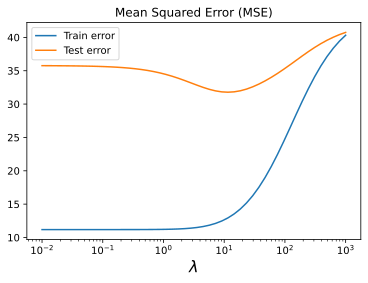

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()

plot_train_test_errors(train_errors, test_errors, lambd_values)

**Camino de regularización**

Como se esperaba, el aumento de λ conduce los parámetros hacia 0. En un ejemplo del mundo real, aquellos parámetros que se acercan a cero más lentamente que otros podrían corresponder a las características más informativas. 

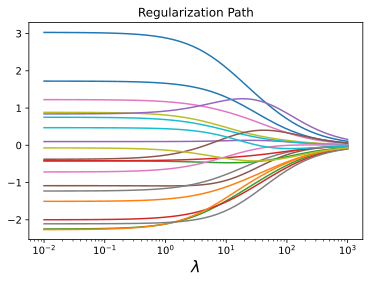

In [6]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()

plot_regularization_path(lambd_values, beta_values)

Links:

https://www.cvxpy.org/examples/machine_learning/ridge_regression.html

https://medium.com/@rrfd/what-is-ridge-regression-applications-in-python-6ed3acbb2aaf

https://iartificial.net/regularizacion-lasso-l1-ridge-l2-y-elasticnet/